# House Prices - Advanced Regression Techniques
Predict sales prices and practice feature engineering, RFs, and gradient boosting

In [2131]:
import numpy as np
import pandas as pd 
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
%matplotlib inline

In [2132]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Delete all data with too many NULL values.

In [2133]:
threshold = 0.2
train_data = train_data.loc[:, train_data.isnull().mean() <= threshold]
test_data = test_data.loc[:, test_data.isnull().mean() <= threshold]

In [2134]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

See which of the quantitaive catgories have the highets correlation with SalePrice.

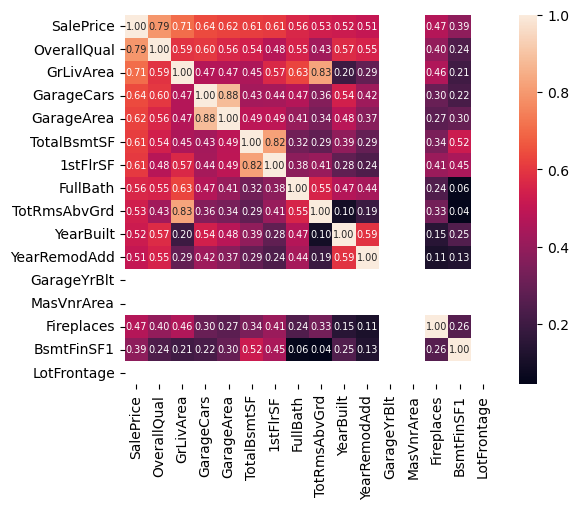

In [2135]:
numeric_df = train_data.select_dtypes(include=["number"])

correl = numeric_df.corr()

k = 16 #number of variables for heatmap
cols = correl.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(numeric_df[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


Now that we have outlined the categories we will use we can prune away any possible outliers.

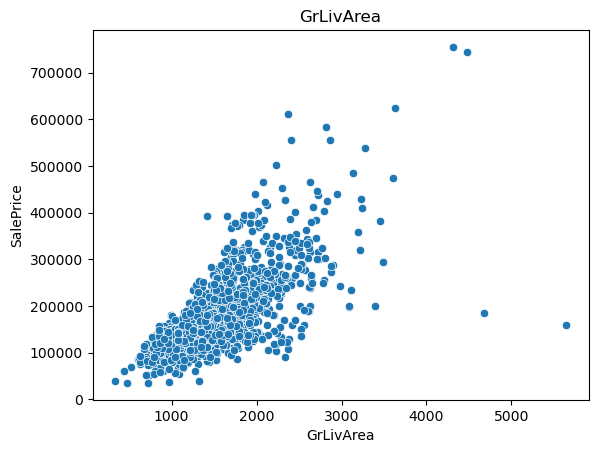

In [2136]:
sns.scatterplot(data=train_data, x='GrLivArea', y='SalePrice')
plt.title('GrLivArea')
plt.show()

train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

Manually go through each of the qualitative categories and see which ones have the most correlation with SalePrice. Then, to make the data usable by Lasso, transform the quantitative values into numeric equivalents.

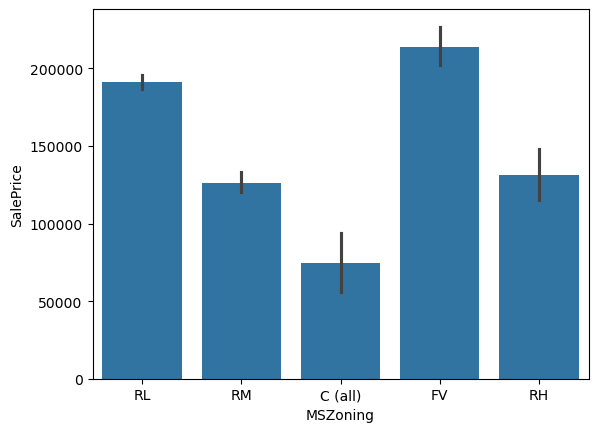

('Electrical', 'KitchenQual', 'SaleCondition', 'LotFrontage')

In [2137]:
sns.barplot(data = train_data, x = 'MSZoning',y = 'SalePrice')
plt.show()

"LandContour", "Street", "Utilities", "Condition2"
#Qualitative to Convert: 
# Street: Pave = 1 Grvl = 0
# LandContour: Bnk = 0, Lvl = 1, Low = 2, HLS = 3
# Utilities: AllPub = 1, NoSeWa = 0
# Condition2 RRNn = 0 , Artery = 1, Feedr = 2, RRAn = 3, Norm = 4, RRAe = 5, PosA = 6, PosN = 7

"BsmtQual", "BsmtCond", "Heating", "HeatingQC", "CentralAir", "HouseStyle"
# BsmtQual: Fa = 0, TA = 1, Gd = 2, Ex = 3    #Get rid of Nan  
# BsmtCond: Po = 0, Fa = 1, TA = 2, Gd = 3    #Get rid of Nan  
# Heating: Grav = 0, Floor = 1, Wall = 2, OthW = 3, GasW = 4, GasA = 5 
# HeatingQC: Po = 0, Fa = 1, TA = 2, Gd = 3, Ex = 4 
# CentralAir: Y = 1, N = 0  
# HouseStyle 1.5Unf = 0, SFoyer = 1 1.5Fin = 2, 2.5Unf = 3, SLvl = 4, 1Story = 5, 2Story = 6, 2.5Fin = 7

"Electrical", "KitchenQual", "SaleCondition", "LotFrontage"
# Electrical: Mix = 0, FueseP = 1, FuseF = 2 FuseA = 3, SBrkr = 4
# KitchenQual: Fa = 0, TA = 1, Gd = 2, Ex = 3
# SaleCondition AdjLand = 0, Abnorml = 1, Family = 2, Alloca=3 Normal = 4, Partial = 5
# MSZoning: C (all) = 0, RM = 1, RH = 2, RL = 3, FV = 4


In [2138]:
#test_data.info()

In [2139]:
combine = [train_data, test_data]

for dataset in combine:

    dataset['MSZoning'] = dataset['MSZoning'].replace('C (all)', 0)
    dataset['MSZoning'] = dataset['MSZoning'].replace('RM', 1)
    dataset['MSZoning'] = dataset['MSZoning'].replace('RH', 2)
    dataset['MSZoning'] = dataset['MSZoning'].replace('RL', 3)
    dataset['MSZoning'] = dataset['MSZoning'].replace('FV', 4)

    dataset['MSZoning'] = dataset['MSZoning'].fillna(0)

    dataset['Electrical'] = dataset['Electrical'].replace('Mix', 0)
    dataset['Electrical'] = dataset['Electrical'].replace('FuseP', 1)
    dataset['Electrical'] = dataset['Electrical'].replace('FuseF', 2)
    dataset['Electrical'] = dataset['Electrical'].replace('FuseA', 3)
    dataset['Electrical'] = dataset['Electrical'].replace('SBrkr', 4)

    dataset['Electrical'] = dataset['Electrical'].fillna(0)


    dataset['KitchenQual'] = dataset['KitchenQual'].replace('Fa', 0)
    dataset['KitchenQual'] = dataset['KitchenQual'].replace('TA', 1)
    dataset['KitchenQual'] = dataset['KitchenQual'].replace('Gd', 2)
    dataset['KitchenQual'] = dataset['KitchenQual'].replace('Ex', 3)

    dataset['KitchenQual'] = dataset['KitchenQual'].fillna(0)


    dataset['SaleCondition'] = dataset['SaleCondition'].replace('AdjLand', 0)
    dataset['SaleCondition'] = dataset['SaleCondition'].replace('Abnorml', 1)
    dataset['SaleCondition'] = dataset['SaleCondition'].replace('Family', 2)
    dataset['SaleCondition'] = dataset['SaleCondition'].replace('Alloca', 3)
    dataset['SaleCondition'] = dataset['SaleCondition'].replace('Normal', 4)
    dataset['SaleCondition'] = dataset['SaleCondition'].replace('Partial', 5)

    dataset['SaleCondition'] = dataset['SaleCondition'].fillna(0)


    dataset['HouseStyle'] = dataset['HouseStyle'].replace('1.5Unf', 0)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('SFoyer', 1)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('1.5Fin', 2)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('2.5Unf', 3)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('SLvl', 4)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('1Story', 5)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('2Story', 6)
    dataset['HouseStyle'] = dataset['HouseStyle'].replace('2.5Fin', 7)

    dataset['HouseStyle'] = dataset['HouseStyle'].fillna(0)
   

    dataset['Heating'] = dataset['Heating'].replace('Grav', 0)
    dataset['Heating'] = dataset['Heating'].replace('Floor',1)
    dataset['Heating'] = dataset['Heating'].replace('Wall', 2)
    dataset['Heating'] = dataset['Heating'].replace('OthW', 3)
    dataset['Heating'] = dataset['Heating'].replace('GasW', 4)
    dataset['Heating'] = dataset['Heating'].replace('GasA', 5)

    dataset['Heating'] = dataset['Heating'].fillna(0)


    dataset['HeatingQC'] = dataset['HeatingQC'].replace('Po', 0)
    dataset['HeatingQC'] = dataset['HeatingQC'].replace('Fa', 1)
    dataset['HeatingQC'] = dataset['HeatingQC'].replace('TA', 2)
    dataset['HeatingQC'] = dataset['HeatingQC'].replace('Gd', 3)
    dataset['HeatingQC'] = dataset['HeatingQC'].replace('Ex', 4)

    dataset['HeatingQC'] = dataset['HeatingQC'].fillna(0)


    dataset['BsmtCond'] = dataset['BsmtCond'].replace('Po', 0)
    dataset['BsmtCond'] = dataset['BsmtCond'].replace('Fa', 1)
    dataset['BsmtCond'] = dataset['BsmtCond'].replace('TA', 2)
    dataset['BsmtCond'] = dataset['BsmtCond'].replace('Gd', 3)

    dataset['BsmtCond'] = dataset['BsmtCond'].fillna(0)


    dataset['CentralAir'] = dataset['CentralAir'].replace('Y', 1)
    dataset['CentralAir'] = dataset['CentralAir'].replace('N', 0)

    dataset['CentralAir'] = dataset['CentralAir'].fillna(0)


    dataset['BsmtQual'] = dataset['BsmtQual'].replace('Fa', 0)
    dataset['BsmtQual'] = dataset['BsmtQual'].replace('TA', 1)
    dataset['BsmtQual'] = dataset['BsmtQual'].replace('Gd', 2)
    dataset['BsmtQual'] = dataset['BsmtQual'].replace('Ex', 3)

    dataset['BsmtQual'] = dataset['BsmtQual'].fillna(0)


    dataset['Street'] = dataset['Street'].replace('Pave', 1)
    dataset['Street'] = dataset['Street'].replace('Grvl', 0)

    dataset['LandContour'] = dataset['LandContour'].replace('Bnk', 0)
    dataset['LandContour'] = dataset['LandContour'].replace('Lvl', 1)
    dataset['LandContour'] = dataset['LandContour'].replace('Low', 2)
    dataset['LandContour'] = dataset['LandContour'].replace('HLS', 3)

    dataset['Utilities'] = dataset['Utilities'].replace('AllPub', 1)
    dataset['Utilities'] = dataset['Utilities'].replace('NoSeWa', 0)

    dataset['Condition2'] = dataset['Condition2'].replace('RRNn', 0)
    dataset['Condition2'] = dataset['Condition2'].replace('Artery', 1)
    dataset['Condition2'] = dataset['Condition2'].replace('Feedr', 2)
    dataset['Condition2'] = dataset['Condition2'].replace('RRAn', 3)
    dataset['Condition2'] = dataset['Condition2'].replace('Norm', 4)
    dataset['Condition2'] = dataset['Condition2'].replace('RRAe', 5)
    dataset['Condition2'] = dataset['Condition2'].replace('PosA', 6)
    dataset['Condition2'] = dataset['Condition2'].replace('PosN', 7)

    dataset['Utilities'] = dataset['Utilities'].fillna(0)


/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_54259/3839131762.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['MSZoning'] = dataset['MSZoning'].replace('FV', 4)
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_54259/3839131762.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['Electrical'] = dataset['Electrical'].replace('SBrkr', 4)
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_54259/3839131762.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will

Normalize the quantitative data.

In [2140]:
Using_Lasso = True

if Using_Lasso == True:
    train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

    train_data["GrLivArea"] = np.log1p(train_data["GrLivArea"])
    test_data["GrLivArea"] = np.log1p(test_data["GrLivArea"])

    train_data["TotalBsmtSF"] = np.log1p(train_data["TotalBsmtSF"])
    test_data["TotalBsmtSF"] = np.log1p(test_data["TotalBsmtSF"])

    train_data["1stFlrSF"] = np.log1p(train_data["1stFlrSF"])
    test_data["1stFlrSF"] = np.log1p(test_data["1stFlrSF"])

    train_data['YearBuilt'] = train_data['YearBuilt'] - 1872
    test_data['YearBuilt'] = test_data['YearBuilt'] - 1879

    train_data["YearBuilt"] = np.log1p(train_data["YearBuilt"])
    test_data["YearBuilt"] = np.log1p(test_data["YearBuilt"])

    train_data['YearRemodAdd'] = train_data['YearRemodAdd'] - 1950
    test_data['YearRemodAdd'] = test_data['YearRemodAdd'] - 1950

    train_data['GarageYrBlt'] = train_data['GarageYrBlt'] - 1900
    test_data['GarageYrBlt'] = test_data['GarageYrBlt'] - 1895

    train_data["GarageYrBlt"] = np.log1p(train_data["GarageYrBlt"])
    test_data["GarageYrBlt"] = np.log1p(test_data["GarageYrBlt"])

    train_data["MasVnrArea"] = np.log1p(train_data["MasVnrArea"])
    test_data["MasVnrArea"] = np.log1p(test_data["MasVnrArea"])

    train_data["BsmtFinSF1"] = np.log1p(train_data["BsmtFinSF1"])
    test_data["BsmtFinSF1"] = np.log1p(test_data["BsmtFinSF1"])

    train_data["LotFrontage"] = np.log1p(train_data["LotFrontage"])
    test_data["LotFrontage"] = np.log1p(test_data["LotFrontage"])



Fill in any NULL values.

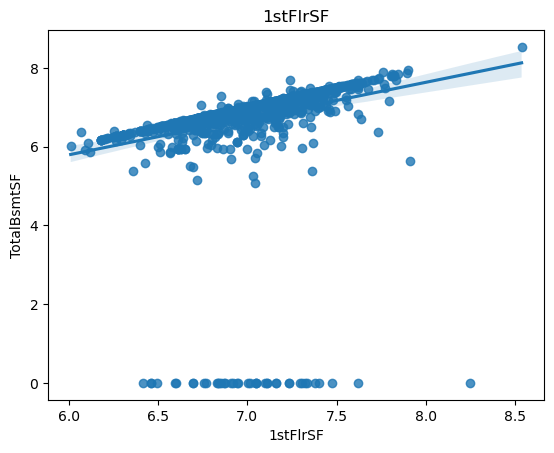

y = 0.92x + 0.26


In [2141]:
sns.regplot(data=test_data, x='1stFlrSF', y='TotalBsmtSF')
plt.title('1stFlrSF')
plt.show()

new_frame = pd.DataFrame({'1stFlrSF': test_data['1stFlrSF'],'TotalBsmtSF': test_data['TotalBsmtSF']})

new_frame = new_frame.dropna()

x = new_frame['1stFlrSF']
y = new_frame['TotalBsmtSF']

m, b = np.polyfit(x, y, 1)

# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")

test_data['TotalBsmtSF'] = test_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['TotalBsmtSF']) else row['TotalBsmtSF'] ,axis= 1)

In [2142]:
mean_cars = test_data['GarageCars'].mean()

test_data['GarageCars'] = test_data['GarageCars'].fillna(mean_cars)

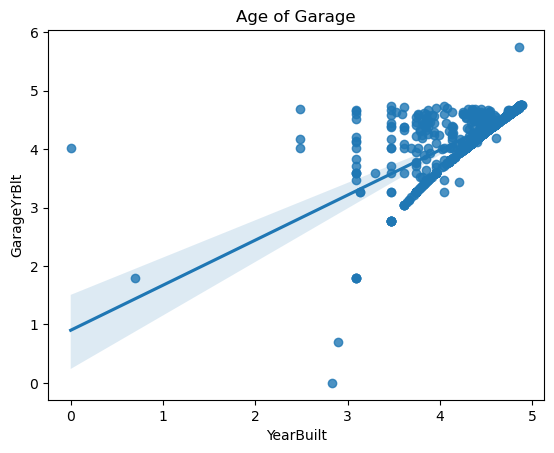

y = 0.77x + 0.90


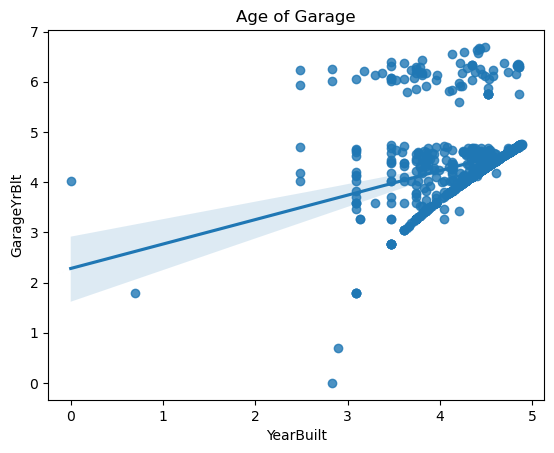

y = 0.79x + 0.72


In [2143]:
sns.regplot(data=test_data, x='YearBuilt', y='GarageYrBlt')
plt.title('Age of Garage')
plt.show()

new_frame = pd.DataFrame({'YearBuilt': test_data['YearBuilt'],'GarageYrBlt': test_data['GarageYrBlt']})
new_frame = new_frame.dropna()
x = new_frame['YearBuilt']
y = new_frame['GarageYrBlt']
m, b = np.polyfit(x, y, 1)
# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")
test_data['GarageYrBlt'] = test_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt'] ,axis= 1)

sns.regplot(data=test_data, x='YearBuilt', y='GarageYrBlt')
plt.title('Age of Garage')
plt.show()

new_frame = pd.DataFrame({'YearBuilt': train_data['YearBuilt'],'GarageYrBlt': train_data['GarageYrBlt']})
new_frame = new_frame.dropna()
x = new_frame['YearBuilt']
y = new_frame['GarageYrBlt']
m, b = np.polyfit(x, y, 1)
# Print the equation of the line
print(f"y = {m:.2f}x + {b:.2f}")
train_data['GarageYrBlt'] = train_data.apply(lambda row: row['1stFlrSF'] * m + b if pd.isna(row['GarageYrBlt']) else row['GarageYrBlt'] ,axis= 1)

In [2144]:
Mas_Area = train_data['MasVnrArea'].mean()
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(Mas_Area)

Mas_Area = test_data['MasVnrArea'].mean()
test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(Mas_Area)

In [2145]:
means = train_data.groupby('MSSubClass')['LotFrontage'].transform('mean')
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(means)

test_data['LotFrontage'] = test_data['LotFrontage'].fillna(means)

Use lasso to create a model.

In [2146]:
y = train_data["SalePrice"]

if Using_Lasso:
    features = ["MSZoning","LotFrontage","MasVnrArea","Electrical", "KitchenQual", "SaleCondition","BsmtQual", "BsmtCond", "Heating", 
                "HeatingQC", "CentralAir", "HouseStyle","Utilities","LandContour", "Street", "Condition2","GarageYrBlt",
                "Fireplaces","OverallQual","GrLivArea","TotalBsmtSF","GarageCars","1stFlrSF","FullBath","TotRmsAbvGrd", 
                "YearBuilt" ,"YearRemodAdd"]

    model_lasso = LassoCV(alphas = [1,0.1,.01, 0.001, 0.0005]).fit(train_data[features], train_data['SalePrice'])
    lasso_preds = np.expm1(model_lasso.predict(test_data[features]))

    solution = pd.DataFrame({"Id":test_data.Id, "SalePrice":lasso_preds})
    solution.to_csv("Predictions.csv", index = False)
    


Lasso Score : .14244